### Importing the libraries

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from PreprocessingClass import Preprocessing_Data as pp
from statsmodels.api import OLS

In [345]:
# fill missing values having missing values
def fillnull(df, cols=None):
    
    if cols == None:
        df_num = df.select_dtypes(include=np.number)
        # df_cat = df.select_dtypes(exclude=np.number)

        df_num = df_num.fillna(df_num.mean())
        # df_cat = df_cat.fillna(df_cat.mode().iloc[0,0])
        return df_num#.join(df_cat)
    else:
        df_num = df[cols].select_dtypes(include=np.number)
        # df_cat = df[cols].select_dtypes(exclude=np.number)

        df_num = df_num.fillna(df_num.mean())
        # df_cat = df_cat.fillna(df_cat.mode().iloc[0,0])
        return df_num#.join(df_cat)[cols]

# compare between values_count for train df and  values_count for validation df
def value_counts(train_df, vld_df, cols=None):
    if cols == None:
        cols = train_df.select_dtypes(exclude=np.number).columns

    for col in cols:
        print(train_df[col].value_counts(), len(train_df[col].value_counts()), '\nT','~'*30,'\n')
        print(vld_df[col].value_counts(),len(vld_df[col].value_counts()), '\nV','~'*30,'\n')

### Loading the dataset 🟩

In [346]:
df = pd.read_csv('data/house_train.csv').drop(columns=['Id'])

In [347]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Handling Missing Values train 🟩

In [348]:
# drop columns having missing values more than 45%
pp.detected_null_value(df, presentage_of_null=45, drop_columns=True)

drop columns:  ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


,index,Counter,presentage of null value
71,PoolQC,1453,99.52
73,MiscFeature,1406,96.30
5,Alley,1369,93.77
72,Fence,1179,80.75
56,FireplaceQu,690,47.26


In [349]:
fill_col = pp.detected_null_value(df, presentage_of_null=10)['index'].tolist()
print(fill_col)
df[fill_col] = fillnull(df, cols=fill_col)

['LotFrontage']


In [350]:
# drop rows having missing values
pp.detected_null_value(df, presentage_of_null=0, drop_rows=True)

drop rows in :  ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea', 'Electrical']


,index,Counter,presentage of null value
55,GarageType,81,5.55
56,GarageYrBlt,81,5.55
57,GarageFinish,81,5.55
60,GarageQual,81,5.55
61,GarageCond,81,5.55
30,BsmtExposure,38,2.60
33,BsmtFinType2,38,2.60
28,BsmtQual,37,2.53
29,BsmtCond,37,2.53
31,BsmtFinType1,37,2.53


### Split Data into Train and Vld 🟢

In [351]:
house_train, house_vld = train_test_split(df, test_size=0.25, random_state=2022)

In [352]:
house_train.shape, house_vld.shape

((1003, 75), (335, 75))

### Handling Redundant Columns train 🟩

In [353]:
# drop columns that contain data redundancy 80% or more
duplicate_cols = pp.detected_redundant(house_train, threshold=81, drop_columns=True,  return_cols=True)

redundant features:  ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SaleType', 'SaleCondition']
redundant features are dropped


### Handling Redundant Columns vld 🟦

In [354]:
# drop columns that contain data redundancy 80% or more
house_vld.drop(columns=duplicate_cols, inplace=True)

### Split Data into Numeric and Categorical train 🟩

In [355]:
num_col, cat_col = pp.separate_data(house_train, cols_only=True)

In [356]:
num_col.shape, cat_col.shape

((28,), (18,))

### Handling Highly Correlated Features 🟩

In [457]:
plt.figure(figsize=(25, 25))
sns.heatmap(house_train[num_col].corr(), annot=True, linewidths=0.5, fmt='.2f',  cmap='coolwarm');

NameError: name 'sns' is not defined

<Figure size 1800x1800 with 0 Axes>

In [358]:
house_train[num_col].corr()['SalePrice'].abs().sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.785001
GrLivArea       0.692018
GarageCars      0.652386
GarageArea      0.613693
1stFlrSF        0.592153
TotalBsmtSF     0.580446
FullBath        0.574509
TotRmsAbvGrd    0.553975
YearBuilt       0.513225
YearRemodAdd    0.501035
GarageYrBlt     0.495614
MasVnrArea      0.485986
Fireplaces      0.437020
WoodDeckSF      0.333671
OpenPorchSF     0.332969
BsmtFinSF1      0.329690
LotFrontage     0.324470
2ndFlrSF        0.306904
LotArea         0.298267
HalfBath        0.261588
BsmtUnfSF       0.204669
BsmtFullBath    0.200065
BedroomAbvGr    0.167477
OverallCond     0.113944
MSSubClass      0.073955
MoSold          0.028668
YrSold          0.012454
Name: SalePrice, dtype: float64

In [359]:
high_corr_list = pp.detected_highly_corr(df=house_train[num_col], target_name=house_train[num_col].columns[-1], threshold=0.75)

we will drop the column  GarageYrBlt
we will drop the column  TotalBsmtSF
we will drop the column  TotRmsAbvGrd
we will drop the column  GarageArea


In [360]:
house_train.drop(high_corr_list, axis=1, inplace=True)
house_vld.drop(high_corr_list, axis=1, inplace=True)

In [361]:
num_col, cat_col = pp.separate_data(house_train, cols_only=True)

In [362]:
num_col.shape, cat_col.shape

((24,), (18,))

### Handling Outliers 🟩

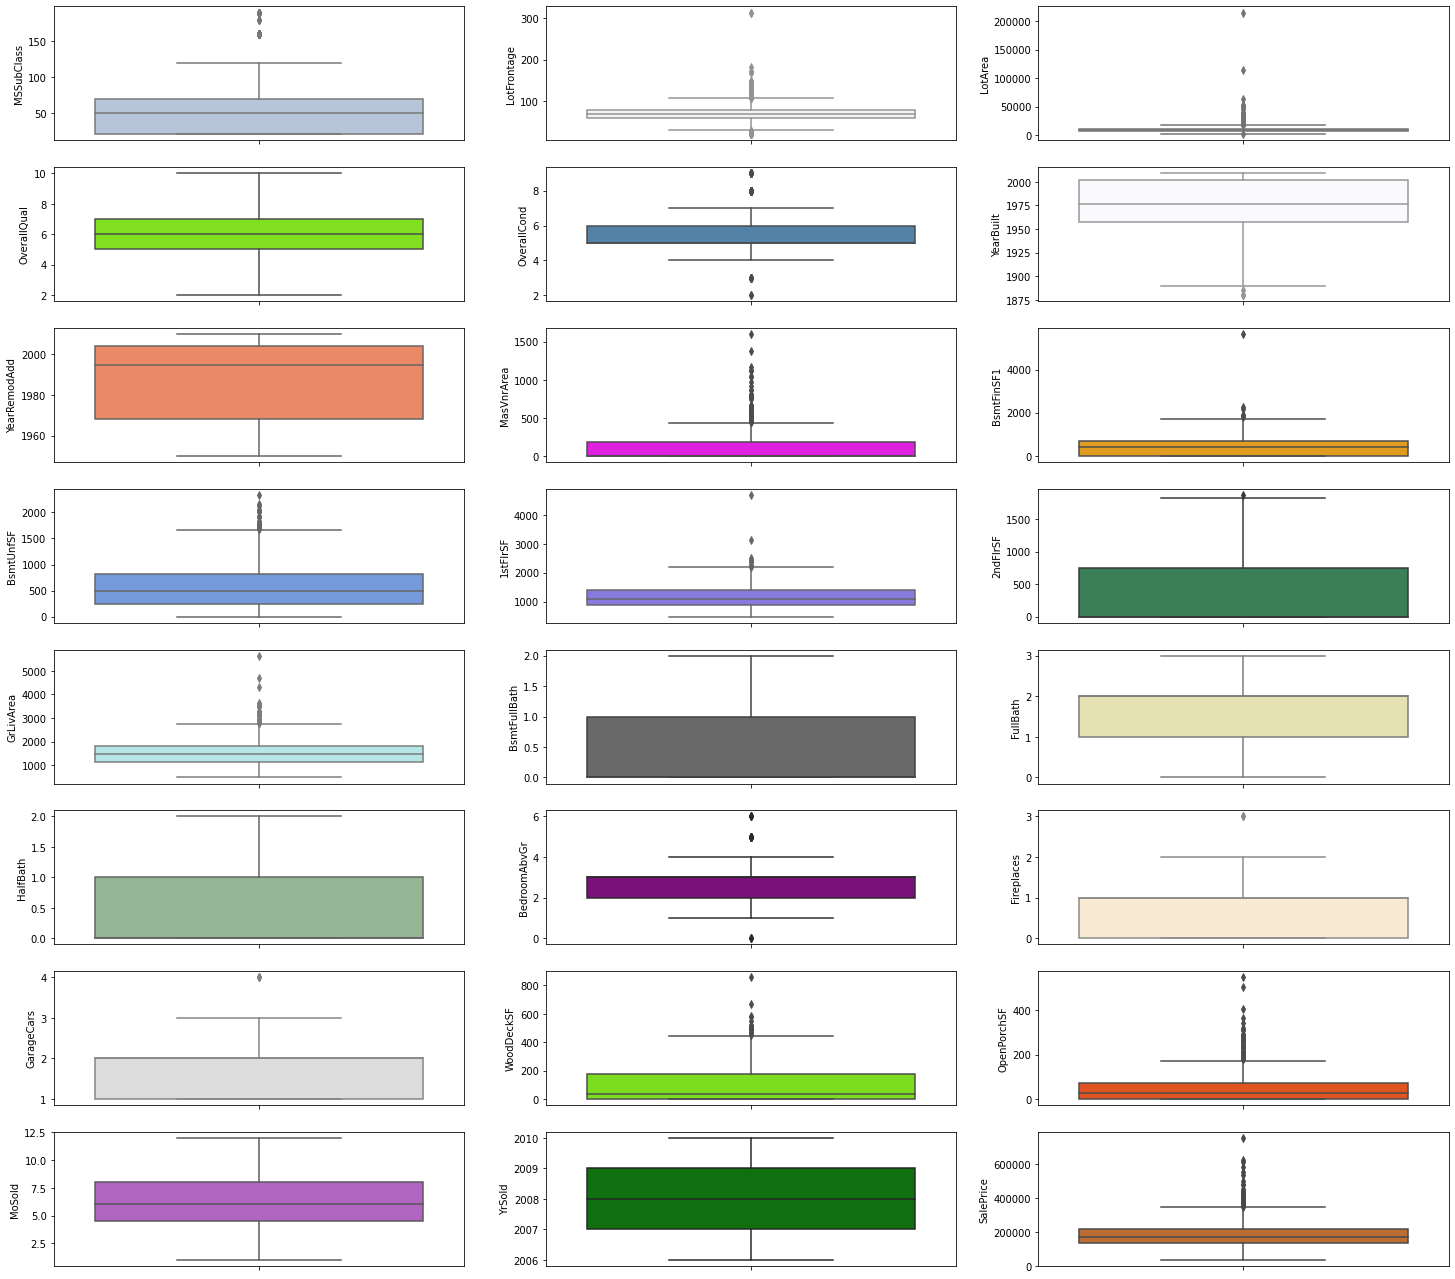

In [363]:
# after clipping outliers
pp.boxplot(house_train[num_col], figsize=(25, 35))

In [364]:
# # clamp the outliers
# house_train[num_col[:-1]] = pp.detected_outliers(house_train[num_col[:-1]], threshold=3, clipping=True)

### Handling Skewed Features 🟩

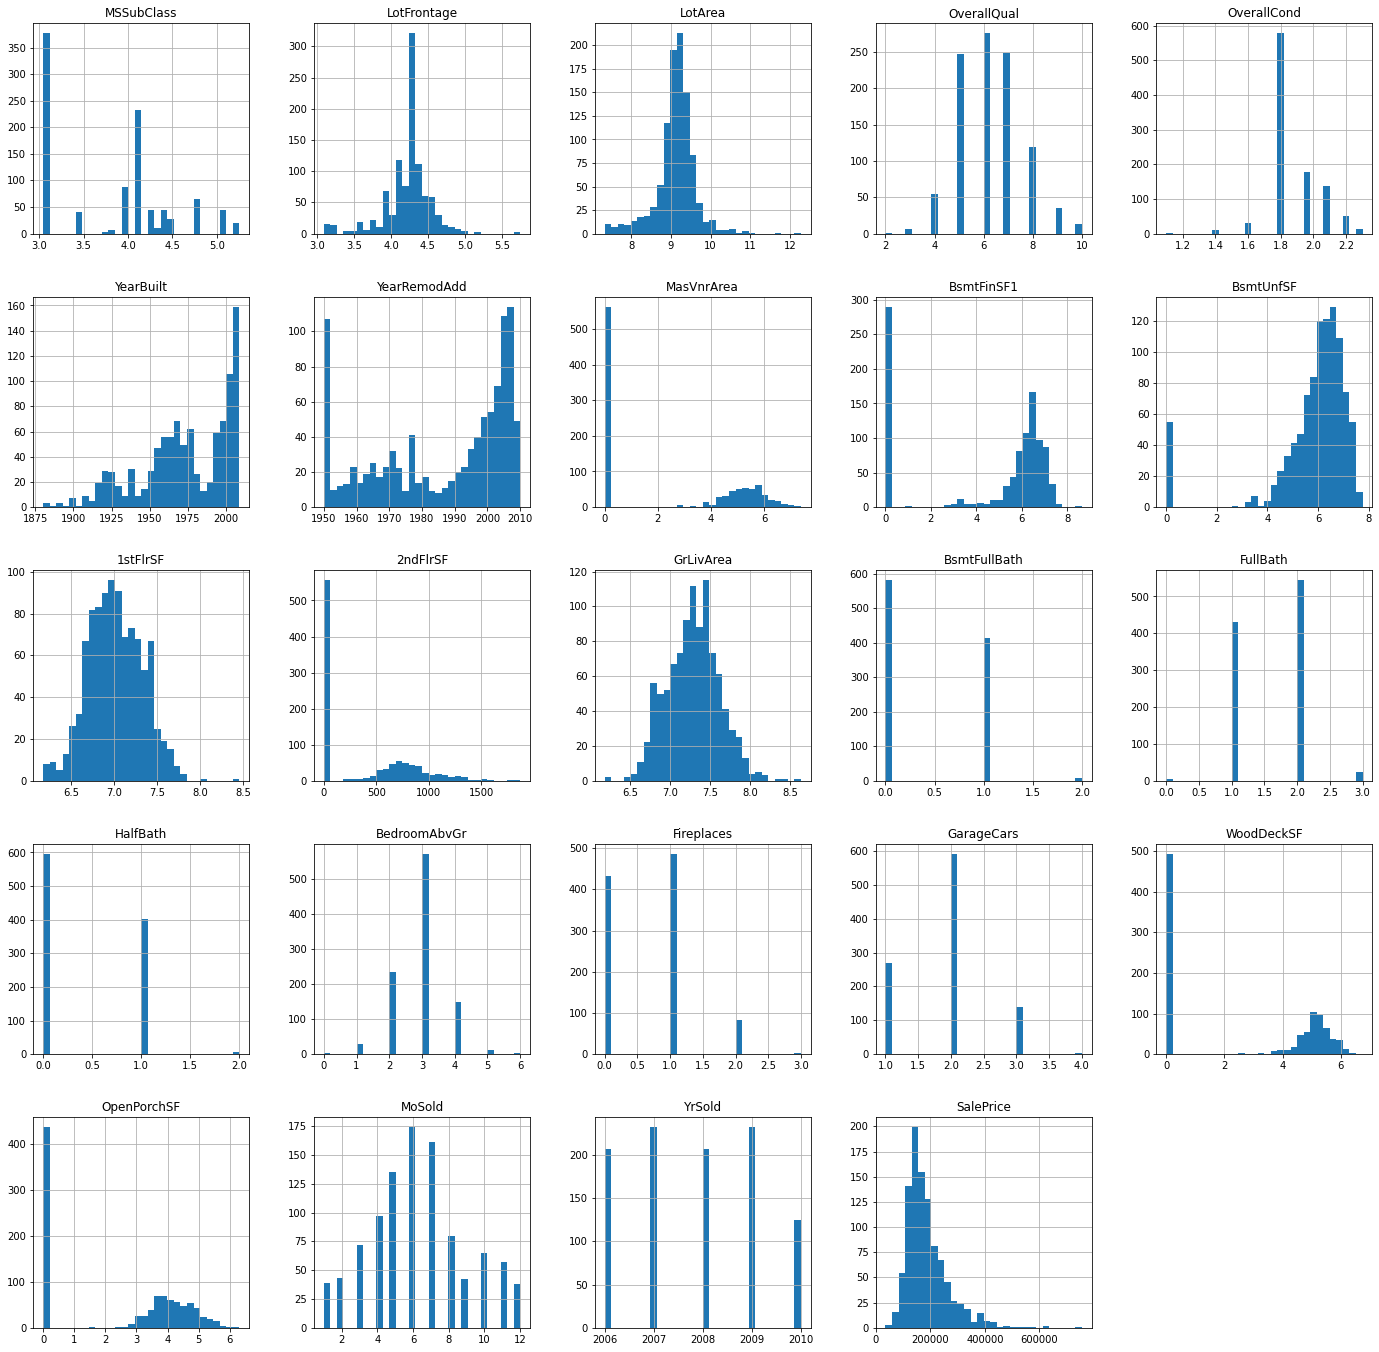

In [458]:
pp.histplot(house_train[num_col])

In [366]:
house_train[num_col].skew().abs().sort_values(ascending=False)

LotArea         13.682839
LotFrontage      2.885199
MasVnrArea       2.644001
OpenPorchSF      2.351311
BsmtFinSF1       1.994983
SalePrice        1.872283
GrLivArea        1.486002
1stFlrSF         1.444967
MSSubClass       1.402379
WoodDeckSF       1.355916
BsmtUnfSF        0.951662
OverallCond      0.907703
2ndFlrSF         0.743501
YearBuilt        0.684718
YearRemodAdd     0.559015
HalfBath         0.499056
Fireplaces       0.489173
BsmtFullBath     0.467961
OverallQual      0.296549
GarageCars       0.205266
MoSold           0.201548
YrSold           0.091633
BedroomAbvGr     0.037956
FullBath         0.014216
dtype: float64

In [367]:
pp.skewness_calc(house_train[num_col[:-1]])

-Skewness Columns:  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']


In [368]:
house_train[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']] = log_transform(house_train[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']])
house_vld[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']] = log_transform(house_vld[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']])

LotArea
LotFrontage
MasVnrArea


C:\Users\SM\AppData\Local\Temp\ipykernel_10292\476885684.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.log(df[col]+1)


OpenPorchSF
BsmtFinSF1
GrLivArea
1stFlrSF
MSSubClass
WoodDeckSF
BsmtUnfSF
OverallCond
LotArea
MasVnrArea
OpenPorchSF
WoodDeckSF


C:\Users\SM\AppData\Local\Temp\ipykernel_10292\476885684.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.log(df[col]+1)


MSSubClass
1stFlrSF
GrLivArea
BsmtUnfSF
LotFrontage
OverallCond
BsmtFinSF1


#### Performs the Shapiro-Wilk test with alpha = 0.01 Test Dataset

In [369]:
pp.shapiro_test(df=house_train[num_col], alpha=0.01)

+ Column '['1stFlrSF', 'GrLivArea']' is normally distributed (std)
- Column '['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice']' is 'not' normally distributed (minmax)


### Min-max scale the non-gaussian features, and standardize the gaussian features 🟩

In [370]:
X_train_Scale, X_vld_Scale = pp.scaling(house_train[num_col], house_vld[num_col], 'robust')

### Encoding Categorical Data 🟩

In [371]:
ordinal_cats = ['BsmtQual', 'LotShape', 'HeatingQC', 'BsmtFinType1',  'ExterQual', 'KitchenQual', 'BsmtExposure', 'GarageFinish']
nominal_cats = ['HouseStyle', 'LotConfig', 'RoofStyle', 'GarageType', 'Exterior1st', 'Foundation', 'MSZoning', 'Exterior2nd', 'MasVnrType', 'Neighborhood']

In [372]:
# house_vld_cat, house_vld_num = pp.separate_data(house_vld, cols_only=False)
house_train.shape, house_vld.shape

((1003, 42), (335, 42))

#### Encoding Categorical Variables Train, Test Dataset

In [373]:
house_train_cat_nominal, house_vld_cat_nominal = pp.encoding_nominal_cat(df_train=house_train, nominal_cats=nominal_cats, df_test=house_vld)
house_train_cat_ordinal, house_vld_cat_ordinal = pp.encoding_ordinal_cat(df_train=house_train, ordinal_cats=ordinal_cats, df_test=house_vld)

In [374]:
house_train_cat_nominal.drop(columns=ordinal_cats, inplace=True)
house_vld_cat_nominal.drop(columns=ordinal_cats, inplace=True)

In [375]:
house_train_cat_nominal.shape, house_vld_cat_nominal.shape, house_train_cat_ordinal.shape, house_vld_cat_ordinal.shape

((1003, 118), (335, 118), (1003, 8), (335, 8))

### final Re-Collecting Data 🟩 

In [376]:
house_train_final = house_train_cat_ordinal.merge(house_train_cat_nominal, left_index=True, right_index=True, how='inner')
house_train_final[num_col] = X_train_Scale
house_vld_final   = house_vld_cat_ordinal.merge(house_vld_cat_nominal, left_index=True, right_index=True, how='inner')
house_vld_final[num_col] = X_vld_Scale

In [377]:
house_train_final.shape, house_vld_final.shape

((702, 126), (77, 126))

In [378]:
house_train_final.isnull().sum().sum()

0

#### split the data into X, y

In [379]:
X_train = house_train_final.iloc[:, :-1]
y_train = house_train_final.iloc[:, -1]

X_vld = house_vld_final.iloc[:, :-1]
y_vld = house_vld_final.iloc[:, -1]

### Modeling

#### SVR

In [339]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


In [319]:
# pca = PCA(random_state=2020, n_components=0.75)
# pca_tr = pca.fit_transform(X_train)
# pca_vld = pca.transform(X_vld)

In [342]:
# kernel = ['linear', 'poly', 'rbf']
# gamma = ['scale', 0.01, 0.001, 0.5, 0.8]
# CC = [0.3, 0.5, 1, 12, 31, 55, 100]
# degree = [3, 4, 5, 6, 7, 8, 9]
# para_svr = {'kernel': kernel, 'gamma': gamma, 'C': CC, 'degree': degree}
# grid_search = GridSearchCV(SVR(), para_svr, cv=5, scoring='r2', n_jobs=-1)
# grid_search.fit(pca_tr, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(r2_score(y_vld, grid_search.predict(pca_vld)))
# print(r2_score(y_train, grid_search.predict(pca_tr)))
# print(mean_squared_error(y_vld, grid_search.predict(pca_vld)))

In [400]:
kernel = ['linear', 'poly', 'rbf']
gamma = ['scale', 0.01, 0.001, 0.5, 0.8]
CC = [0.3, 0.5, 1, 12, 31, 55, 100]
degree = [3, 4, 5, 6, 7, 8, 9]

In [405]:
def evaluate_model(y_true, y_pred):
    print('R2:', r2_score(y_true, y_pred))
    print('MSE:', mean_squared_error(y_true, y_pred))

##### kernel poly

In [401]:
for c in CC:
    for g in gamma:
        for d in degree:
            svr = SVR(kernel='poly', C=c, gamma=g, degree=d)
            svr.fit(X_train, y_train)
            y_pred = svr.predict(X_vld)
            print(c,g,d,r2_score(y_train, svr.predict(X_train)), mean_squared_error(y_train, svr.predict(X_train)))
            print(c,g,d,r2_score(y_vld, y_pred), mean_squared_error(y_vld, y_pred))

0.3 scale 3 0.791047947587306 0.1961326361365252
0.3 scale 3 0.8271788606377707 0.09853737885376553
0.3 scale 4 0.7639562503056005 0.22156223083980653
0.3 scale 4 0.78134416278776 0.12467093521939066
0.3 scale 5 0.742301334065051 0.24188859642719054
0.3 scale 5 0.7276546774070478 0.1552830535108592
0.3 scale 6 0.7195860125091091 0.2632103104090009
0.3 scale 6 0.6703396552233896 0.1879623430686356
0.3 scale 7 0.6964080645544652 0.284966268199743
0.3 scale 7 0.6244256573080699 0.21414111392947416
0.3 scale 8 0.6739291295695482 0.3060660981618128
0.3 scale 8 0.576039885552769 0.2417292153630071
0.3 scale 9 0.6540641122498934 0.32471237690764887
0.3 scale 9 0.5168637657181745 0.2754696464280719
0.3 0.01 3 0.6621565412927233 0.31711642643675697
0.3 0.01 3 0.7432776214189417 0.1463753240595187
0.3 0.01 4 0.5679666190749377 0.4055277032285338
0.3 0.01 4 0.6560203404591262 0.1961267826103466
0.3 0.01 5 0.47344191602597474 0.4942532217144631
0.3 0.01 5 0.5572955504818963 0.2524166674481898
0.3 

In [409]:
svr = SVR(kernel='poly', C=55, gamma=0.01, degree=3)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_vld)

evaluate_model(y_train, svr.predict(X_train))
evaluate_model(y_vld, y_pred)

R2: 0.9905862745340743
MSE: 0.008836184044035618
R2: 0.7568354326048023
MSE: 0.13864507079201277


##### kernel linear

In [ ]:
for c in CC:
    svr = SVR(kernel='linear', C=c)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_vld)
    print(c,r2_score(y_train, svr.predict(X_train)), mean_squared_error(y_train, svr.predict(X_train)))
    print(c,r2_score(y_vld, y_pred), mean_squared_error(y_vld, y_pred))

In [412]:
svr = SVR(kernel='linear', C=0.3)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_vld)
evaluate_model(y_train, svr.predict(X_train)), evaluate_model(y_vld, y_pred)

R2: 0.8516385317358852
MSE: 0.1392593445995675
R2: 0.8743348417987309
MSE: 0.07165046676635393


(None, None)

##### kernel rbf

In [413]:
for c in CC:
    for g in gamma:
        svr = SVR(kernel='rbf', C=c, gamma=g)
        svr.fit(X_train, y_train)
        y_pred = svr.predict(X_vld)
        print(c,g,r2_score(y_train, svr.predict(X_train)), mean_squared_error(y_train, svr.predict(X_train)))
        print(c,g,r2_score(y_vld, y_pred), mean_squared_error(y_vld, y_pred))

0.3 scale 0.8045060630326384 0.18350018946158464
0.3 scale 0.8336726764356613 0.09483480178567819
0.3 0.01 0.7925317976549022 0.1947398217466755
0.3 0.01 0.8307100575416425 0.09652399734032255
0.3 0.001 0.5909904771874784 0.3839163817147969
0.3 0.001 0.629346135327827 0.2113356064055468
0.3 0.5 0.29175188018157083 0.6647963931187839
0.3 0.5 -0.14394749345822921 0.6522442102146255
0.3 0.8 0.29131607817644956 0.6652054582373652
0.3 0.8 -0.14601042304665945 0.6534204301791157
0.5 scale 0.841571112705167 0.14870911745791646
0.5 scale 0.8559170509482046 0.08215173322822962
0.5 0.01 0.8273207100872622 0.16208524369924326
0.5 0.01 0.8572382946456394 0.0813984000928694
0.5 0.001 0.670286671646571 0.30948508766778277
0.5 0.001 0.721374498234134 0.15886382144651018
0.5 0.5 0.4608240884839112 0.5060969329848992
0.5 0.5 -0.10696150085437961 0.6311559175500963
0.5 0.8 0.46066292284811583 0.5062482109486147
0.5 0.8 -0.10956092771096193 0.6326380320062035
1 scale 0.8829635309115393 0.1098561652847215

In [414]:
svr = SVR(kernel='rbf', C=12, gamma='scale')
svr.fit(X_train, y_train)
y_pred = svr.predict(X_vld)
evaluate_model(y_train, svr.predict(X_train)), evaluate_model(y_vld, y_pred)

R2: 0.9787291047426631
MSE: 0.019965904673506604
R2: 0.8270821874341563
MSE: 0.0985924989862025


(None, None)

In [ ]:
# kernel = ['linear', 'poly', 'rbf']
# gamma = ['scale', 0.01, 0.001, 0.5, 0.8]
# CC = [0.3, 0.5, 1, 12, 31, 55, 100]
# degree = [3, 4, 5, 6, 7, 8, 9]
# para_svr = {'kernel': kernel, 'gamma': gamma, 'C': CC, 'degree': degree}
# grid_search = GridSearchCV(SVR(), para_svr, cv=5, scoring='r2', n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(r2_score(y_vld, grid_search.predict(X_vld)))
# print(r2_score(y_train, grid_search.predict(X_train)))
# print(mean_squared_error(y_vld, grid_search.predict(X_vld)))

In [415]:
OLS(y_train, X_train).fit().summary().tables[0]

Dep. Variable:,SalePrice,R-squared:,0.873
Model:,OLS,Adj. R-squared:,0.851
Method:,Least Squares,F-statistic:,38.28
Date:,"Wed, 01 Jun 2022",Prob (F-statistic):,2.46e-207
Time:,04:06:35,Log-Likelihood:,-248.59
No. Observations:,702,AIC:,713.2
Df Residuals:,594,BIC:,1205.
Df Model:,107,,
Covariance Type:,nonrobust,,


#### Regression

In [419]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_vld)
evaluate_model(y_train, reg.predict(X_train)), evaluate_model(y_vld, y_pred)

R2: 0.8733494497737302
MSE: 0.11888041298086158
R2: -1.3309537161709282e+21
MSE: 7.588694939238717e+20


(None, None)

In [418]:
poly_reg = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly_reg.fit_transform(X_train)
X_poly_vld = poly_reg.transform(X_vld)
# ---------------------------------------------------------- #
reg = LinearRegression()
reg.fit(X_poly, y_train)
y_pred = reg.predict(X_poly_vld)
evaluate_model(y_train, reg.predict(X_poly)), evaluate_model(y_vld, y_pred)

R2: 1.0
MSE: 1.0847704376620805e-27
R2: 0.7030046806395502
MSE: 0.16933773501097354


(None, None)

In [ ]:
poly_reg = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly_reg.fit_transform(X_train)
X_poly_vld = poly_reg.transform(X_vld)
# ---------------------------------------------------------- #
reg = LinearRegression()
reg.fit(X_poly, y_train)
y_pred = reg.predict(X_poly_vld)
evaluate_model(y_train, reg.predict(X_poly)), evaluate_model(y_vld, y_pred)

#### comparing basis exponention between SVR vs Poly Feature Regression

In [421]:
svr = SVR(kernel='poly', C=55, gamma=0.01, degree=50)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_vld)

evaluate_model(y_train, svr.predict(X_train))
evaluate_model(y_vld, y_pred)

R2: 0.25370074874151427
MSE: 0.700513049792611
R2: -0.3457686595811582
MSE: 0.767316525906754


In [443]:
poly_reg = PolynomialFeatures(degree=50, include_bias=False)
X_poly = poly_reg.fit_transform(X_train)
X_poly_vld = poly_reg.transform(X_vld)
# ---------------------------------------------------------- #
reg = LinearRegression()
reg.fit(X_poly, y_train)
y_pred = reg.predict(X_poly_vld)
evaluate_model(y_train, reg.predict(X_poly)), evaluate_model(y_vld, y_pred)

ValueError: Maximum allowed dimension exceeded

<li>
After trying found Support Vector Regression memory consumption and running time 16.5s. because SVR is that it does not perform explicit basis expansion of the inputs but
uses the kernel trick instead, so it is more efficient than Polynomial Feature Regression in terms of both time and memory.

</li>